<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Playground/Testset_2021_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Loading and cleaning data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  NRC_2021.json  Telegraaf_2021.json  Trouw_2021.json


In [4]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'

In [5]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)

In [6]:
df_NRC["Bron"] = "NRC"
df_Trouw["Bron"] = "Trouw"
df_HetParool["Bron"] = "HetParool"
df_Telegraaf["Bron"] = "Telegraaf"

## Reformat date

In [12]:
# Clean date data NRC
df_NRC['date'] = df_NRC['timestamp'].map(lambda x: x.date())

,url,timestamp,title,publisherID,cleantext,category,Bron,date
0,https://www.nrc.nl/nieuws/2021/02/28/loonongel...,2021-02-28 23:01:54+02:00,Loonongelijkheid sinds 2006 toegenomen,Belia Heilbron,De loonongelijkheid in Nederland is sinds 2006...,None,NRC,2021-02-28
1,https://www.nrc.nl/nieuws/2021/02/28/ruim-3-pr...,2021-02-28 23:01:43+02:00,Ruim 3 procent meer bijstandsuitkeringen eind ...,Steven Musch,Eind vorig jaar ontvingen 429 duizend Nederlan...,None,NRC,2021-02-28
2,https://www.nrc.nl/nieuws/2021/02/28/het-debat...,2021-02-28 22:48:24+02:00,Het debat is afgelopen,Kees Rottinghuis,Het eerste grote tv-debat tussen lijsttrekkers...,None,NRC,2021-02-28
3,https://www.nrc.nl/nieuws/2021/02/28/vijf-lijs...,2021-02-28 22:46:56+02:00,Vijf lijsttrekkers vallen Kaag af: geen voorra...,Rik Rutten,Moeten gevaccineerden voorrang krijgen bij het...,None,NRC,2021-02-28
4,https://www.nrc.nl/nieuws/2021/02/28/kiezer-ma...,2021-02-28 22:31:01+02:00,"Niet een lijsttrekker, maar een kiezer brengt ...",Lamyae Aharouay,Een tv-format kan een beslissende rol spelen i...,None,NRC,2021-02-28


In [16]:
df_Trouw.head()

,url,timestamp,title,publisherID,cleantext,category,Bron
0,http://trouw.nl/nieuws/kamer-wil-alle-gedupeer...,1 februari 2021,Kamer wil álle gedupeerden van zwarte lijst Be...,Esther Lammers,\n \n \n In een Kamerbrede motie ...,voorpagina,Trouw
1,http://trouw.nl/nieuws/vo-raad-laat-middelbare...,1 februari 2021,VO-Raad: laat middelbare scholieren minstens é...,Redactie Trouw,\n \n \n \n \n ...,None,Trouw
2,http://trouw.nl/nieuws/je-zag-het-al-maanden-f...,1 februari 2021,Je zag het al maanden fout gaan met die twee,Willem Schoonen,met een gewiekst onderzoekje. De wetenschapper...,wetenschap,Trouw
3,http://trouw.nl/nieuws/omt-leden-lek-ondermijn...,1 februari 2021,OMT-leden: lek ondermijnt onze werkwijze,Johan van Heerde,\n \n \n Ook hoogleraar ouderenge...,politiek,Trouw
4,http://trouw.nl/nieuws/uva-studenten-houden-ac...,1 februari 2021,UvA-studenten houden actieweek tegen seksueel ...,Redactie Trouw,\n \n \n “De klachtencommissie en...,binnenland,Trouw


In [21]:
df_Trouw['date'] = df_Trouw['timestamp']
df_Trouw.head()

,url,timestamp,title,publisherID,cleantext,category,Bron,date
0,http://trouw.nl/nieuws/kamer-wil-alle-gedupeer...,1 februari 2021,Kamer wil álle gedupeerden van zwarte lijst Be...,Esther Lammers,\n \n \n In een Kamerbrede motie ...,voorpagina,Trouw,1 februari 2021
1,http://trouw.nl/nieuws/vo-raad-laat-middelbare...,1 februari 2021,VO-Raad: laat middelbare scholieren minstens é...,Redactie Trouw,\n \n \n \n \n ...,None,Trouw,1 februari 2021
2,http://trouw.nl/nieuws/je-zag-het-al-maanden-f...,1 februari 2021,Je zag het al maanden fout gaan met die twee,Willem Schoonen,met een gewiekst onderzoekje. De wetenschapper...,wetenschap,Trouw,1 februari 2021
3,http://trouw.nl/nieuws/omt-leden-lek-ondermijn...,1 februari 2021,OMT-leden: lek ondermijnt onze werkwijze,Johan van Heerde,\n \n \n Ook hoogleraar ouderenge...,politiek,Trouw,1 februari 2021
4,http://trouw.nl/nieuws/uva-studenten-houden-ac...,1 februari 2021,UvA-studenten houden actieweek tegen seksueel ...,Redactie Trouw,\n \n \n “De klachtencommissie en...,binnenland,Trouw,1 februari 2021


In [ ]:
df_date = df_Trouw['timestamp']

ConversionError: ignored

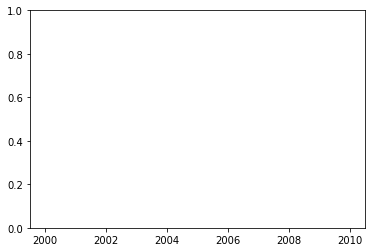

In [59]:
sns.histplot(data=df, x='timestamp')

## Concat data

In [7]:
dfs = [df_NRC, df_Trouw, df_HetParool, df_Telegraaf]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Bron
0,https://www.nrc.nl/nieuws/2021/02/28/loonongel...,2021-02-28 23:01:54+02:00,Loonongelijkheid sinds 2006 toegenomen,Belia Heilbron,De loonongelijkheid in Nederland is sinds 2006...,None,NRC
1,https://www.nrc.nl/nieuws/2021/02/28/ruim-3-pr...,2021-02-28 23:01:43+02:00,Ruim 3 procent meer bijstandsuitkeringen eind ...,Steven Musch,Eind vorig jaar ontvingen 429 duizend Nederlan...,None,NRC
2,https://www.nrc.nl/nieuws/2021/02/28/het-debat...,2021-02-28 22:48:24+02:00,Het debat is afgelopen,Kees Rottinghuis,Het eerste grote tv-debat tussen lijsttrekkers...,None,NRC
3,https://www.nrc.nl/nieuws/2021/02/28/vijf-lijs...,2021-02-28 22:46:56+02:00,Vijf lijsttrekkers vallen Kaag af: geen voorra...,Rik Rutten,Moeten gevaccineerden voorrang krijgen bij het...,None,NRC
4,https://www.nrc.nl/nieuws/2021/02/28/kiezer-ma...,2021-02-28 22:31:01+02:00,"Niet een lijsttrekker, maar een kiezer brengt ...",Lamyae Aharouay,Een tv-format kan een beslissende rol spelen i...,None,NRC


In [8]:
df.head()

,url,timestamp,title,publisherID,cleantext,category,Bron
0,https://www.nrc.nl/nieuws/2021/02/28/loonongel...,2021-02-28 23:01:54+02:00,Loonongelijkheid sinds 2006 toegenomen,Belia Heilbron,De loonongelijkheid in Nederland is sinds 2006...,None,NRC
1,https://www.nrc.nl/nieuws/2021/02/28/ruim-3-pr...,2021-02-28 23:01:43+02:00,Ruim 3 procent meer bijstandsuitkeringen eind ...,Steven Musch,Eind vorig jaar ontvingen 429 duizend Nederlan...,None,NRC
2,https://www.nrc.nl/nieuws/2021/02/28/het-debat...,2021-02-28 22:48:24+02:00,Het debat is afgelopen,Kees Rottinghuis,Het eerste grote tv-debat tussen lijsttrekkers...,None,NRC
3,https://www.nrc.nl/nieuws/2021/02/28/vijf-lijs...,2021-02-28 22:46:56+02:00,Vijf lijsttrekkers vallen Kaag af: geen voorra...,Rik Rutten,Moeten gevaccineerden voorrang krijgen bij het...,None,NRC
4,https://www.nrc.nl/nieuws/2021/02/28/kiezer-ma...,2021-02-28 22:31:01+02:00,"Niet een lijsttrekker, maar een kiezer brengt ...",Lamyae Aharouay,Een tv-format kan een beslissende rol spelen i...,None,NRC


## Remove missing text

In [9]:
df = df[df['cleantext'].notna()]

In [10]:
df.isna().sum()


url               0
timestamp      2580
title             2
publisherID    3743
cleantext         0
category       5196
Bron              0
dtype: int64

# Preprocessing

In [11]:
# Remove the columns
articles = df.drop(columns=['url', 'publisherID', 'category',], axis=1)# Print out the first rows of papers
articles.head()

,timestamp,title,cleantext,Bron
0,2021-02-28 23:01:54+02:00,Loonongelijkheid sinds 2006 toegenomen,De loonongelijkheid in Nederland is sinds 2006...,NRC
1,2021-02-28 23:01:43+02:00,Ruim 3 procent meer bijstandsuitkeringen eind ...,Eind vorig jaar ontvingen 429 duizend Nederlan...,NRC
2,2021-02-28 22:48:24+02:00,Het debat is afgelopen,Het eerste grote tv-debat tussen lijsttrekkers...,NRC
3,2021-02-28 22:46:56+02:00,Vijf lijsttrekkers vallen Kaag af: geen voorra...,Moeten gevaccineerden voorrang krijgen bij het...,NRC
4,2021-02-28 22:31:01+02:00,"Niet een lijsttrekker, maar een kiezer brengt ...",Een tv-format kan een beslissende rol spelen i...,NRC


In [12]:
articles.size

68944

In [15]:
# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50PLUS', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

0    de loonongelijkheid in nederland is sinds 2006...
1    eind vorig jaar ontvingen 429 duizend nederlan...
2    het eerste grote tv-debat tussen lijsttrekkers...
3    moeten gevaccineerden voorrang krijgen bij het...
4    een tv-format kan een beslissende rol spelen i...
Name: cleantext_processed, dtype: object

In [16]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['nederland', 'sinds', 'toegenomen', 'lag', 'brutoloon', 'hoogste', 'tien', 'procent', 'uurlonen', 'keer', 'hoger', 'laagste', 'tien', 'procent', 'bedroeg', 'factor', 'blijkt', 'onderzoek', 'cbs', 'maandag', 'publiceert']


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1)]


In [18]:
# number of topics
num_topics = 7
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [19]:
def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df


In [20]:
df_tt = terms_topics_frame(['pvv', 'groenlinks', 'pvda', 'sp',
                            'dzeszes', 'vvd', 'sgp',
                            'bbb', 'volt', 'cu', 'cda',
                            'fvd', 'bijeen', 'vijfplus', 'pvdd',
                            'jatweeeen']
)
df_tt['topic'] = df_tt.index
df_tt.head()

,pvv,groenlinks,pvda,sp,dzeszes,vvd,sgp,bbb,volt,cu,cda,fvd,bijeen,vijfplus,pvdd,jatweeeen,topic
0,0.000045,0.000052,0.000035,0.000026,0.000071,0.000083,0.000008,0.000005,0.000010,9.043142e-07,0.000100,0.000041,0.000058,3.128879e-07,5.709410e-06,0.000013,0
1,0.000224,0.000361,0.000630,0.000240,0.000833,0.001196,0.000063,0.000022,0.000048,3.296376e-05,0.001058,0.000059,0.000048,5.895255e-06,2.153142e-05,0.000066,1
2,0.000055,0.000110,0.000102,0.000091,0.000160,0.000236,0.000016,0.000006,0.000023,3.118686e-06,0.000354,0.000048,0.000029,5.188091e-08,6.303784e-06,0.000030,2
3,0.000015,0.000028,0.000030,0.000029,0.000047,0.000071,0.000011,0.000003,0.000004,6.906565e-07,0.000061,0.000013,0.000043,5.013244e-08,9.881328e-07,0.000004,3
4,0.000028,0.000070,0.000085,0.000028,0.000086,0.000088,0.000015,0.000007,0.000011,7.871310e-06,0.000109,0.000015,0.000034,4.447405e-08,3.386981e-06,0.000005,4


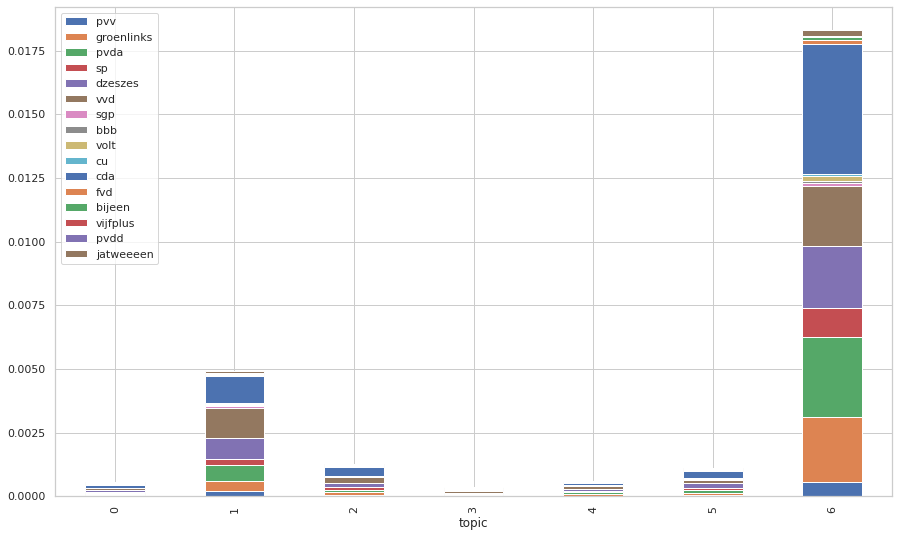

In [23]:
sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.077142 -0.018581       1        1  39.084050
1      0.007228 -0.009559       2        1  21.405467
3      0.019272  0.009007       3        1  12.960581
0     -0.037747  0.049647       4        1   9.799850
5      0.009045  0.034234       5        1   7.956047
6     -0.021143 -0.018070       6        1   7.089138
2     -0.053797 -0.046679       7        1   1.704867, topic_info=        Term          Freq         Total Category  logprob  loglift
32      jaar  21488.000000  21488.000000  Default  30.0000  30.0000
132   mensen  19350.000000  19350.000000  Default  29.0000  29.0000
168       we  29840.000000  29840.000000  Default  28.0000  28.0000
161  volgens  10877.000000  10877.000000  Default  27.0000  27.0000
174     zegt  13891.000000  13891.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
625     waar    135.014938  13847.238391   Topic7  -6.2671  -0.5588
134   moeten    129.984070  11692.956744   Topic7  -6.3051  -0.4276
789   nieuwe    126.176968   9500.320052   Topic7  -6.3348  -0.2497
170     weer    128.092322  11622.322021   Topic7  -6.3197  -0.4362
128    maken    114.942997   9667.827906   Topic7  -6.4281  -0.3604

[696 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
19         1  0.179148        aantal
19         2  0.307438        aantal
19         3  0.131818        aantal
19         4  0.169184        aantal
19         5  0.114381        aantal
...      ...       ...           ...
51698      3  0.006785          zuma
51698      4  0.929608          zuma
51698      5  0.027142          zuma
41008      7  0.759425        zverev
90719      1  0.975559  zweefvliegen

[2563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 6, 7, 3])